In [3]:
from torch.utils.data import DataLoader
from dataset import AudioInstrumentDataset
import torch.nn as nn
import numpy as np
from model import CNNInstrumentClassifier
from constants import *
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sequence_length = int(SAMPLE_RATE * 0.5)
train_data = AudioInstrumentDataset(r"train_metadata.csv", sequence_length=sequence_length)
val_data = AudioInstrumentDataset(r"test_metadata.csv", sequence_length=sequence_length)

train_loader = DataLoader(
    train_data, 
    batch_size=32, 
    shuffle=True, 
    num_workers=4, 
    persistent_workers=True,
    pin_memory=True
)

val_loader = DataLoader(
    val_data, 
    batch_size=64, 
    shuffle=False, 
    num_workers=4,
    persistent_workers=True,
    pin_memory=True
)

model = CNNInstrumentClassifier().to(device)

def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validating", leave=False)
        for x, y in pbar:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item() * y.size(0)
            correct += outputs.argmax(dim=1).eq(y).sum().item()
            total += y.size(0)
    return total_loss / total, correct / total
def train(train_loader, val_loader, model, n_epochs=50):
    opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    scheduler = CosineAnnealingLR(opt, T_max=n_epochs, eta_min=1e-6)
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    best_acc = 0
    patience = 5
    patience_counter = 0
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(n_epochs):
        model.train()
        epoch_loss, epoch_correct, epoch_total = 0.0, 0, 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs}')
        for x, y in pbar:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            
            opt.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            opt.step()
            
            epoch_loss += loss.item() * y.size(0)
            epoch_correct += outputs.argmax(dim=1).eq(y).sum().item()
            epoch_total += y.size(0)
            
            train_loss = epoch_loss / epoch_total
            train_acc = epoch_correct / epoch_total
            pbar.set_postfix({
                'loss': f'{train_loss:.4f}',
                'acc': f'{train_acc:.2%}',
                'lr': f'{scheduler.get_last_lr()[0]:.6f}'
            })
        
        train_loss = epoch_loss / epoch_total
        train_acc = epoch_correct / epoch_total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        scheduler.step()
        
        print(f'\nEpoch {epoch+1}/{n_epochs}:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}')
        
        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'model saved(val_acc: {val_acc:.2%})\n')
        else:
            patience_counter += 1
            print(f'Early stopping counter: {patience_counter} out of {patience}\n')
            
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
    
    model.load_state_dict(torch.load('best_model.pth'))
    return history

def plot_training_history(history):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Epoch 1/20: 100%|██████████| 73/73 [00:19<00:00,  3.84it/s, loss=1.1267, acc=51.44%, lr=0.001000]



Epoch 1/20:
Train Loss: 1.1267 | Train Acc: 51.44%
Val Loss: 1.1503 | Val Acc: 54.15%
模型已保存 (val_acc: 54.15%)



Epoch 2/20: 100%|██████████| 73/73 [00:18<00:00,  3.91it/s, loss=0.9930, acc=62.42%, lr=0.000994]



Epoch 2/20:
Train Loss: 0.9930 | Train Acc: 62.42%
Val Loss: 1.5602 | Val Acc: 43.86%
Early stopping counter: 1 out of 5



Epoch 3/20: 100%|██████████| 73/73 [00:18<00:00,  3.95it/s, loss=0.9143, acc=68.47%, lr=0.000976]



Epoch 3/20:
Train Loss: 0.9143 | Train Acc: 68.47%
Val Loss: 0.9102 | Val Acc: 77.32%
模型已保存 (val_acc: 77.32%)



Epoch 4/20: 100%|██████████| 73/73 [00:18<00:00,  3.95it/s, loss=0.8068, acc=75.38%, lr=0.000946]



Epoch 4/20:
Train Loss: 0.8068 | Train Acc: 75.38%
Val Loss: 1.8162 | Val Acc: 54.65%
Early stopping counter: 1 out of 5



Epoch 5/20: 100%|██████████| 73/73 [00:18<00:00,  3.94it/s, loss=0.6929, acc=82.45%, lr=0.000905]



Epoch 5/20:
Train Loss: 0.6929 | Train Acc: 82.45%
Val Loss: 0.5215 | Val Acc: 95.10%
模型已保存 (val_acc: 95.10%)



Epoch 6/20: 100%|██████████| 73/73 [00:18<00:00,  3.91it/s, loss=0.6536, acc=83.91%, lr=0.000854]



Epoch 6/20:
Train Loss: 0.6536 | Train Acc: 83.91%
Val Loss: 2.1288 | Val Acc: 64.94%
Early stopping counter: 1 out of 5



Epoch 7/20: 100%|██████████| 73/73 [00:18<00:00,  3.89it/s, loss=0.6344, acc=83.83%, lr=0.000794]



Epoch 7/20:
Train Loss: 0.6344 | Train Acc: 83.83%
Val Loss: 0.4934 | Val Acc: 97.90%
模型已保存 (val_acc: 97.90%)



Epoch 8/20: 100%|██████████| 73/73 [00:18<00:00,  3.88it/s, loss=0.6411, acc=83.57%, lr=0.000727]



Epoch 8/20:
Train Loss: 0.6411 | Train Acc: 83.57%
Val Loss: 0.5289 | Val Acc: 94.51%
Early stopping counter: 1 out of 5



Epoch 9/20: 100%|██████████| 73/73 [00:18<00:00,  3.87it/s, loss=0.5622, acc=89.36%, lr=0.000655]



Epoch 9/20:
Train Loss: 0.5622 | Train Acc: 89.36%
Val Loss: 0.9448 | Val Acc: 83.92%
Early stopping counter: 2 out of 5



Epoch 10/20: 100%|██████████| 73/73 [00:18<00:00,  3.89it/s, loss=0.5923, acc=87.26%, lr=0.000579]



Epoch 10/20:
Train Loss: 0.5923 | Train Acc: 87.26%
Val Loss: 0.5062 | Val Acc: 98.80%
模型已保存 (val_acc: 98.80%)



Epoch 11/20: 100%|██████████| 73/73 [00:18<00:00,  3.90it/s, loss=0.5989, acc=87.09%, lr=0.000501]



Epoch 11/20:
Train Loss: 0.5989 | Train Acc: 87.09%
Val Loss: 0.5460 | Val Acc: 97.60%
Early stopping counter: 1 out of 5



Epoch 12/20: 100%|██████████| 73/73 [00:18<00:00,  3.89it/s, loss=0.5475, acc=89.75%, lr=0.000422]



Epoch 12/20:
Train Loss: 0.5475 | Train Acc: 89.75%
Val Loss: 0.4226 | Val Acc: 99.00%
模型已保存 (val_acc: 99.00%)



Epoch 13/20: 100%|██████████| 73/73 [00:18<00:00,  3.90it/s, loss=0.5682, acc=88.67%, lr=0.000346]



Epoch 13/20:
Train Loss: 0.5682 | Train Acc: 88.67%
Val Loss: 0.5642 | Val Acc: 96.10%
Early stopping counter: 1 out of 5



Epoch 14/20: 100%|██████████| 73/73 [00:18<00:00,  3.87it/s, loss=0.5810, acc=87.17%, lr=0.000274]



Epoch 14/20:
Train Loss: 0.5810 | Train Acc: 87.17%
Val Loss: 0.5459 | Val Acc: 98.60%
Early stopping counter: 2 out of 5



Epoch 15/20: 100%|██████████| 73/73 [00:18<00:00,  3.89it/s, loss=0.5231, acc=90.78%, lr=0.000207]



Epoch 15/20:
Train Loss: 0.5231 | Train Acc: 90.78%
Val Loss: 0.5448 | Val Acc: 96.00%
Early stopping counter: 3 out of 5



Epoch 16/20: 100%|██████████| 73/73 [00:18<00:00,  3.89it/s, loss=0.5213, acc=91.46%, lr=0.000147]



Epoch 16/20:
Train Loss: 0.5213 | Train Acc: 91.46%
Val Loss: 0.4854 | Val Acc: 97.70%
Early stopping counter: 4 out of 5



Epoch 17/20: 100%|██████████| 73/73 [00:18<00:00,  3.85it/s, loss=0.5374, acc=90.26%, lr=0.000096]



Epoch 17/20:
Train Loss: 0.5374 | Train Acc: 90.26%
Val Loss: 0.4591 | Val Acc: 98.50%
Early stopping counter: 5 out of 5

Early stopping triggered after 17 epochs


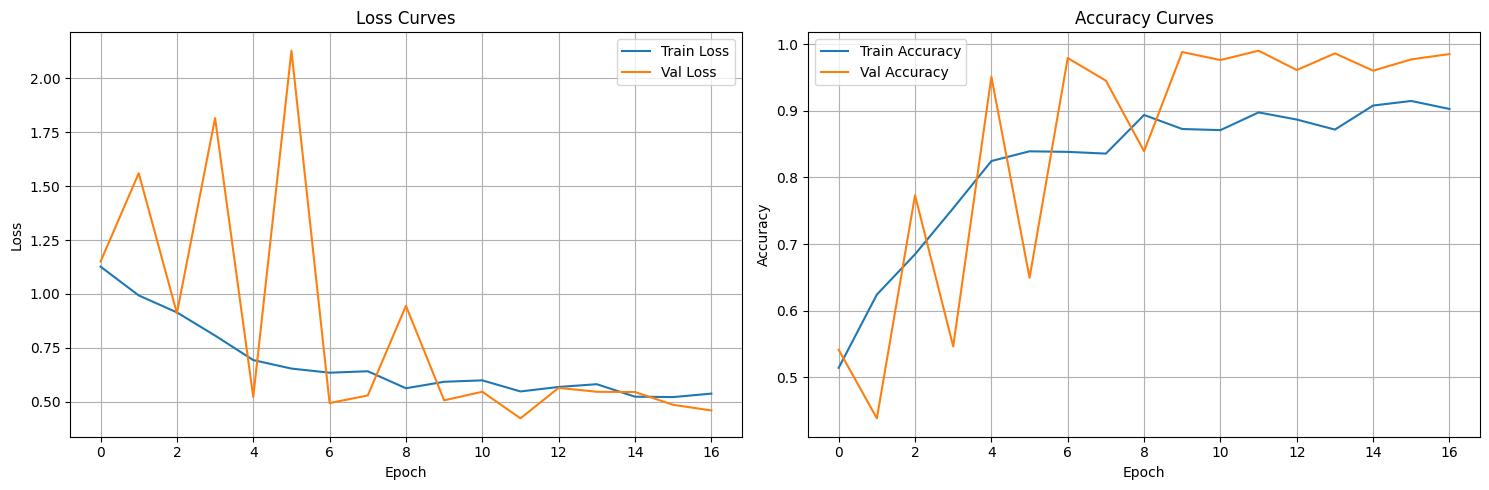

In [4]:
history = train(train_loader, val_loader, model, n_epochs=20)
plot_training_history(history)